In [ ]:
# install some packages not available on colab
!pip install mrcfile
!pip install -U -q PyDrive

In [ ]:
# IGNORE these few cells if you are running this nb locally
# this part links your google drive to this colab notebook
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# once you run this, click on the link and copy the validation code here
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# upload the .mrc file onto google drive and paste the sharing link below
# currently using the "May08_03.05.02.bin.mrc" from the EMPIAR 10146 dataset (apoferritin)
link = "https://drive.google.com/open?id=15he2DJIFYJdjfN2Nf3SAvq6Blmj1IxBN"

In [ ]:
fluff, id = link.split('=')

In [ ]:
# we will use the id part to get the file contents
print(id)May08_03.05.02.bin.mrc

In [ ]:
downloaded = drive.CreateFile({'id':id}) 
# replace filename if necessary
downloaded.GetContentFile('May08_03.05.02.bin.mrc')

In [2]:
# start of actual process to open mrc file
import mrcfile
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys

In [3]:
# replace file name if necessary
file_name = sys.argv[1] 
file_name = "./test_data/shrinked_stacked.mrc"
mrc = mrcfile.open(file_name,mode='r')
# mrc = mrcfile.open('',mode='r')

save_name = "bm3d_filtered.mrc"

In [4]:
img_stack = np.copy(mrc.data)

In [5]:
org_min, org_max = np.min(img_stack), np.max(img_stack)

In [6]:
# convert floating type to int type between 0 and 255 (inclusive)
norm_stack = cv2.normalize(img_stack, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)

In [7]:
norm_stack_expanded=np.expand_dims(norm_stack,axis=3)

In [8]:
# do a 2d transform for a stack of images
def transform_2d(image_stack):
  transformed_stack = np.zeros(image_stack.shape,dtype='float32')
  for i in range(transformed_stack.shape[0]):
    transformed_stack[i] = cv2.dct(image_stack[i])
  return transformed_stack

In [9]:
# reverse the 2d transform
def reverse_transform_2d(transformed_stack):
  filtered_stack = np.zeros(transformed_stack.shape)
  for i in range(filtered_stack.shape[0]):
    filtered_stack[i] = cv2.idct(transformed_stack[i])
  return filtered_stack

In [10]:
# check at this stage if reverse is valid

In [34]:
# threshold is a certain value multiplied by sigma
sigma=1
Threshold_Hard3D = 1.7*sigma

def Step1_3DFiltering_color(_similar_blocks):
    t1 = cv2.getTickCount()
    chnl = _similar_blocks.shape[3] # chnl = 3 for color image
    # statis_nonzero = np.zeros(chnl, dtype=int)
    m_Shape = _similar_blocks.shape
    new_blocks = np.zeros(_similar_blocks.shape)
    # print("similar blocks shape", _similar_blocks.shape)avg_frame

    # code below is computationally expensive

    # for each pixel location at each channel, do cosine transform, hard thresholding and cosine transform back
    for i in range(m_Shape[1]):
        for j in range(m_Shape[2]):
            for ch in range(chnl):
                tem_Vct_Trans = cv2.dct(_similar_blocks[:, i, j, ch])
                if i == 2 and j == 2:
                    print(tem_Vct_Trans)
                tem_Vct_Trans[np.abs(tem_Vct_Trans[:]) < Threshold_Hard3D] = 0.
                if i == 2 and j == 2:
                    print(tem_Vct_Trans)
                # statis_nonzero[ch] += tem_Vct_Trans.nonzero()[0].size
                new_blocks[:, i, j, ch] = cv2.idct(tem_Vct_Trans).flatten()
    t2 = cv2.getTickCount()
    time = (t2-t1)/cv2.getTickFrequency()
    print("Initial step processing time taken is {} seconds".format(time))
    return new_blocks

In [35]:
# sigma can be adjusted
sigma_color = [0, 0, 0]
sigma_color[0] = np.sqrt(0.299*0.299 + 0.587*0.587 + 0.114*0.144)*sigma
sigma_color[1] = np.sqrt(0.169*0.169 + 0.331*0.331 + 0.5*0.5)*sigma
sigma_color[2] = np.sqrt(0.5*0.5 + 0.419*0.419 + 0.081*0.081)*sigma

def Step2_3DFiltering_color(_Similar_Bscs, _Similar_Imgs):
    t1 = cv2.getTickCount()
    chnl = _Similar_Bscs.shape[3] # chnl = 3 for color image
    m_Shape = _Similar_Bscs.shape
    # Wiener_wight = np.zeros((m_Shape[1], m_Shape[2], m_Shape[3]), dtype=float)
    Count = _Similar_Bscs.shape[0]
    final_blocks = np.zeros(_Similar_Bscs.shape)

    # Wiener filtering
    for i in range(m_Shape[1]):
        for j in range(m_Shape[2]):
            for ch in range(chnl):
                tem_vector = _Similar_Bscs[:, i, j, ch]
                tem_Vct_Trans = np.matrix(cv2.dct(tem_vector))
                if i == 2 and j == 2:
                    print(tem_Vct_Trans)
                # find the l2 norm
                Norm_2 = np.float64(tem_Vct_Trans.T * tem_Vct_Trans)

                m_weight = Norm_2/Count/(Norm_2/Count + sigma_color[ch]**2)
                # print("m weight shape", m_weight.shape)
                # print("m_weight = "+str(m_weight))

                tem_vector = _Similar_Imgs[:, i, j, ch]
                tem_Vct_Trans = m_weight * cv2.dct(tem_vector)
                if i == 2 and j == 2:
                    print(tem_Vct_Trans)
                final_blocks[:, i, j, ch] = cv2.idct(tem_Vct_Trans).flatten()
    t2 = cv2.getTickCount()
    time = (t2-t1)/cv2.getTickFrequency()
    print("Final step processing time taken is {} seconds".format(time))
    return final_blocks

In [38]:
def bm3d_cycle(image_stack):
  transformed_stack = transform_2d(image_stack)
  transformed_stack_expanded = np.expand_dims(transformed_stack,axis=3)
  basic_blocks = Step1_3DFiltering_color(transformed_stack_expanded)    
  final_blocks = Step2_3DFiltering_color(basic_blocks, transformed_stack_expanded)
  final_blocks_squeezed = np.squeeze(final_blocks)
  filtered_stack = reverse_transform_2d(final_blocks_squeezed)
  return transformed_stack, filtered_stack

In [39]:
sigma=0.2
Threshold_Hard3D = 1.7*sigma
sigma_color[0] = np.sqrt(0.299*0.299 + 0.587*0.587 + 0.114*0.144)*sigma
org_filtered_stack, transformed_stack = bm3d_cycle(norm_stack)

[[ 11.724281 ]
 [ 28.139776 ]
 [  3.8399472]
 [ -7.238774 ]
 [ -1.1592699]
 [-30.436235 ]
 [  9.226859 ]
 [ 42.705933 ]
 [ 32.68299  ]
 [  5.0213823]
 [-43.79423  ]
 [ -8.636398 ]
 [-88.852844 ]
 [ 27.553291 ]
 [-45.389168 ]
 [  4.956898 ]
 [-21.356167 ]
 [ -7.3932123]
 [-29.596527 ]
 [ 24.925879 ]
 [ -4.961257 ]
 [ 71.74996  ]
 [-18.245085 ]
 [ 23.404469 ]
 [ 16.827593 ]
 [-38.424686 ]
 [-48.213367 ]
 [-15.200766 ]
 [ 40.08712  ]
 [-13.641045 ]
 [  1.0560566]
 [ -0.7880759]
 [-63.011173 ]
 [-19.73467  ]
 [-39.37692  ]
 [ 28.224422 ]
 [-17.254698 ]
 [ 39.898705 ]
 [ 30.853754 ]
 [ 42.442932 ]
 [-39.652325 ]
 [ -6.7604156]
 [  2.1971836]
 [-39.996136 ]
 [  9.776392 ]
 [ 36.80908  ]
 [-13.117126 ]
 [ 16.658901 ]
 [-23.387089 ]
 [ 55.033768 ]]
[[ 11.724281 ]
 [ 28.139776 ]
 [  3.8399472]
 [ -7.238774 ]
 [ -1.1592699]
 [-30.436235 ]
 [  9.226859 ]
 [ 42.705933 ]
 [ 32.68299  ]
 [  5.0213823]
 [-43.79423  ]
 [ -8.636398 ]
 [-88.852844 ]
 [ 27.553291 ]
 [-45.389168 ]
 [  4.956898 ]
 [-21.356

In [24]:
org_filtered_stack[7,:10,:10]

array([[ 3.9845864e+03, -4.1552540e+01, -7.2153912e+00, -8.6407051e+00,
        -7.7138882e+00,  1.6732669e+00, -8.0717020e+00, -2.6319370e+00,
         2.6441634e+00, -2.8286064e+00],
       [ 1.4572638e+01, -7.8835016e-01,  1.1047010e+00,  3.5024190e+00,
        -7.1123356e-01, -6.8150014e-01,  1.2696855e+00, -1.7662362e+00,
         4.1134815e+00,  1.4133743e+00],
       [-1.5865958e+01,  1.0967478e+00, -2.1314597e+00,  8.4918368e-01,
        -2.5232563e+00, -4.8777732e-01, -1.0065656e+00, -5.1542358e+00,
        -6.8004888e-01, -1.3444433e-01],
       [-2.8568144e+00, -2.7391024e+00,  1.5836787e+00, -5.9600635e+00,
         1.8844225e+00, -1.8748907e+00, -6.4923471e-01, -2.2631214e+00,
        -2.3002639e+00, -2.3048428e-01],
       [ 1.1493715e+00, -1.7596208e+00,  7.5014949e-02, -5.5988264e-01,
         2.2364292e+00, -8.3233029e-02,  1.2419389e+00,  2.3819153e+00,
         5.6779053e-02,  1.8429005e+00],
       [-4.5001885e-01, -1.2796332e+00, -2.1386435e+00, -3.7080789e+00,
   

In [17]:
transformed_stack[0,:10,:10]

array([[6.92658974, 7.43237448, 7.07547614, 6.81060908, 7.24276381,
        7.00335499, 6.77254386, 6.84837153, 6.75425647, 6.75217513],
       [4.99277731, 6.24771545, 5.43266862, 4.72314053, 8.04155305,
        7.41758828, 6.26695866, 5.47920424, 5.86810243, 7.42879751],
       [5.55876145, 3.80422997, 6.40947886, 6.13656278, 7.94311342,
        6.5032666 , 6.45402057, 4.47712253, 6.75046798, 6.24235625],
       [5.85360982, 6.44955544, 6.61060978, 7.04947299, 8.35142106,
        8.81437715, 5.85148135, 5.84457717, 6.09936846, 8.6913612 ],
       [4.55500475, 5.14971116, 4.23705928, 6.10277673, 8.20426706,
        8.14836081, 6.24382803, 7.54602366, 6.55343559, 6.08745175],
       [5.79223535, 7.36654191, 5.76745992, 6.00730699, 7.22140408,
        3.72417013, 5.30325793, 6.57025615, 4.76653499, 5.8963167 ],
       [7.31646536, 5.86537288, 5.83949269, 5.8533502 , 6.02039544,
        6.10779749, 3.99572974, 6.69363418, 6.68595156, 4.46880856],
       [6.1853492 , 4.41868154, 7.7808390

In [18]:
img_stack[0,:10,:10]

array([[6.928305 , 7.442484 , 7.0822296, 6.815518 , 7.246369 , 7.003166 ,
        6.77306  , 6.850716 , 6.756585 , 6.7528753],
       [4.9840045, 6.2493696, 5.4272766, 4.70715  , 8.055457 , 7.421117 ,
        6.2691236, 5.4760737, 5.862899 , 7.4353013],
       [5.5577903, 3.7766173, 6.4132633, 6.1383553, 7.9588685, 6.4991207,
        6.4563966, 4.4596734, 6.7609115, 6.232623 ],
       [5.848687 , 6.459608 , 6.6135926, 7.052995 , 8.36976  , 8.8317995,
        5.8461943, 5.845395 , 6.0896006, 8.714954 ],
       [4.541724 , 5.1352725, 4.220336 , 6.1035705, 8.211933 , 8.166047 ,
        6.2399797, 7.5622225, 6.5594583, 6.078645 ],
       [5.787457 , 7.3813753, 5.763562 , 6.005929 , 7.2298822, 3.6984584,
        5.295252 , 6.5715485, 4.7555013, 5.9003077],
       [7.320198 , 5.8604593, 5.8320317, 5.850297 , 6.0166564, 6.1159205,
        3.9770932, 6.7029095, 6.6922817, 4.459597 ],
       [6.1849604, 4.399522 , 7.7970414, 7.397424 , 6.2162757, 5.8267703,
        5.6194544, 6.275491 , 5.44299

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(org_filtered_stack.mean(axis=0),cmap='gray')
plt.show()

In [33]:
transformed_stack = transform_2d(img_stack)
filtered_sigma=0.2
Threshold_Hard3D = 1.7*sigma
sigma_color[0] = np.sqrt(0.299*0.299 + 0.587*0.587 + 0.114*0.144)*sigmastack = reverse_transform_2d(transformed_stack)

In [49]:
sigma=10
Threshold_Hard3D = 2.7*sigma
sigma_color[0] = np.sqrt(0.299*0.299 + 0.587*0.587 + 0.114*0.144)*sigma
transformed_stack, filtered_stack = bm3d_cycle(norm_stack)

[[ 11.724281 ]
 [ 28.139776 ]
 [  3.8399472]
 [ -7.238774 ]
 [ -1.1592699]
 [-30.436235 ]
 [  9.226859 ]
 [ 42.705933 ]
 [ 32.68299  ]
 [  5.0213823]
 [-43.79423  ]
 [ -8.636398 ]
 [-88.852844 ]
 [ 27.553291 ]
 [-45.389168 ]
 [  4.956898 ]
 [-21.356167 ]
 [ -7.3932123]
 [-29.596527 ]
 [ 24.925879 ]
 [ -4.961257 ]
 [ 71.74996  ]
 [-18.245085 ]
 [ 23.404469 ]
 [ 16.827593 ]
 [-38.424686 ]
 [-48.213367 ]
 [-15.200766 ]
 [ 40.08712  ]
 [-13.641045 ]
 [  1.0560566]
 [ -0.7880759]
 [-63.011173 ]
 [-19.73467  ]
 [-39.37692  ]
 [ 28.224422 ]
 [-17.254698 ]
 [ 39.898705 ]
 [ 30.853754 ]
 [ 42.442932 ]
 [-39.652325 ]
 [ -6.7604156]
 [  2.1971836]
 [-39.996136 ]
 [  9.776392 ]
 [ 36.80908  ]
 [-13.117126 ]
 [ 16.658901 ]
 [-23.387089 ]
 [ 55.033768 ]]
[[  0.      ]
 [ 28.139776]
 [  0.      ]
 [  0.      ]
 [  0.      ]
 [-30.436235]
 [  0.      ]
 [ 42.705933]
 [ 32.68299 ]
 [  0.      ]
 [-43.79423 ]
 [  0.      ]
 [-88.852844]
 [ 27.553291]
 [-45.389168]
 [  0.      ]
 [  0.      ]
 [  0.     

In [46]:
# get the original average frame
avg_frame = norm_stack.mean(axis=0)

In [50]:
# get the filtered average frame
avg_filtered_frame = filtered_stack.mean(axis=0)

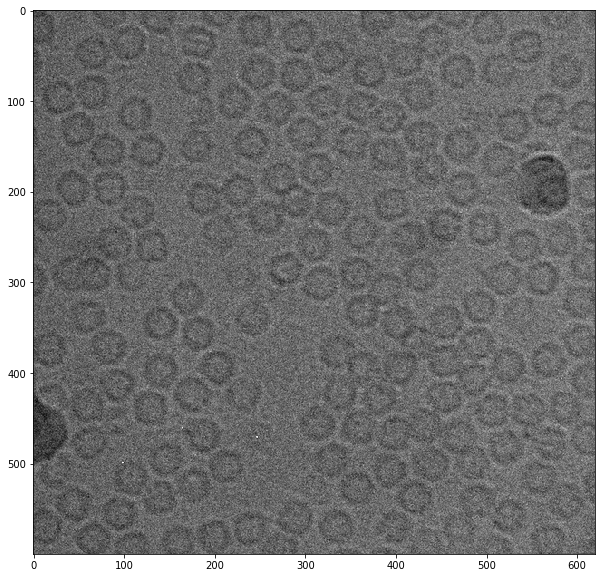

In [51]:
plt.figure(figsize=(20,10))
plt.imshow(avg_filtered_frame,cmap='gray')
plt.show()

In [ ]:
filtered_stack.shape

In [ ]:
scaled_filtered = cv2.normalize(filtered_stack, None, alpha = org_min, beta = org_max, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)

In [ ]:
with mrcfile.new('./test_data/bm3d_filtered.mrc', overwrite=True) as mrc:
    mrc.set_data(scaled_filtered)